# Importación de librerías necesarias

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.calibration import LabelEncoder
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
pd.options.display.max_columns = 0

from warnings import simplefilter
simplefilter("ignore")

# Carga de datos desde "raw"

In [2]:
data = pd.read_csv("../data/raw/atp_matches_2023.csv", sep=";")
data.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,2023-9900,United Cup,Hard,18,A,20230102,300,126203,3.0,NaN,Taylor Fritz,R,193.0,USA,25.1,126610,5.0,NaN,Matteo Berrettini,R,196.0,ITA,26.7,7-6(4) 7-6(6),3,F,135.0,15.0,2.0,85.0,52.0,45.0,16.0,12.0,0.0,0.0,7.0,2.0,97.0,62.0,47.0,15.0,12.0,9.0,9.0,9.0,3355.0,16.0,2375.0
1,2023-9900,United Cup,Hard,18,A,20230102,299,126207,NaN,NaN,Frances Tiafoe,R,188.0,USA,24.9,207518,NaN,NaN,Lorenzo Musetti,R,185.0,ITA,20.8,6-2 0-0 RET,3,F,34.0,3.0,1.0,27.0,19.0,15.0,3.0,4.0,3.0,3.0,0.0,0.0,21.0,12.0,8.0,3.0,4.0,1.0,3.0,19.0,2000.0,23.0,1865.0
2,2023-9900,United Cup,Hard,18,A,20230102,296,126203,3.0,NaN,Taylor Fritz,R,193.0,USA,25.1,128034,2.0,NaN,Hubert Hurkacz,R,196.0,POL,25.8,7-6(5) 7-6(5),3,SF,104.0,11.0,0.0,80.0,50.0,44.0,19.0,12.0,4.0,4.0,17.0,1.0,82.0,62.0,51.0,7.0,12.0,2.0,2.0,9.0,3355.0,10.0,2905.0
3,2023-9900,United Cup,Hard,18,A,20230102,295,126207,NaN,NaN,Frances Tiafoe,R,188.0,USA,24.9,200390,NaN,NaN,Kacper Zuk,R,183.0,POL,23.9,6-3 6-3,3,SF,79.0,5.0,4.0,61.0,37.0,31.0,11.0,9.0,5.0,5.0,3.0,3.0,68.0,41.0,26.0,12.0,9.0,6.0,9.0,19.0,2000.0,245.0,220.0
4,2023-9900,United Cup,Hard,18,A,20230102,292,126774,1.0,NaN,Stefanos Tsitsipas,R,193.0,GRE,24.3,126610,5.0,NaN,Matteo Berrettini,R,196.0,ITA,26.7,4-6 7-6(2) 6-4,3,SF,155.0,9.0,1.0,98.0,52.0,43.0,28.0,16.0,1.0,2.0,7.0,2.0,89.0,58.0,48.0,18.0,16.0,1.0,2.0,4.0,5550.0,16.0,2375.0


# Primer análisis

In [3]:
data.shape

(2242, 49)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2242 entries, 0 to 2241
Data columns (total 49 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tourney_id          2242 non-null   object 
 1   tourney_name        2242 non-null   object 
 2   surface             2242 non-null   object 
 3   draw_size           2242 non-null   int64  
 4   tourney_level       2242 non-null   object 
 5   tourney_date        2242 non-null   int64  
 6   match_num           2242 non-null   int64  
 7   winner_id           2242 non-null   int64  
 8   winner_seed         947 non-null    float64
 9   winner_entry        367 non-null    object 
 10  winner_name         2242 non-null   object 
 11  winner_hand         2242 non-null   object 
 12  winner_ht           2123 non-null   float64
 13  winner_ioc          2242 non-null   object 
 14  winner_age          2242 non-null   float64
 15  loser_id            2242 non-null   int64  
 16  loser_

A primera vista, se ve que hay 2242 filas, y de las 49 columnas hay algunas con valores NaN (profundizaré más abajo en ello)

In [5]:
data.describe().round(2)

,draw_size,tourney_date,match_num,winner_id,winner_seed,winner_ht,winner_age,loser_id,loser_seed,loser_ht,loser_age,best_of,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
count,2242.00,2242.00,2242.00,2242.00,947.00,2123.00,2242.00,2242.00,587.00,2019.00,2238.00,2242.00,2010.00,2129.00,2129.00,2129.00,2129.00,2129.00,2129.00,2129.00,2129.00,2129.00,2129.00,2129.00,2129.00,2129.00,2129.00,2129.00,2129.00,2129.00,2129.00,2231.00,2231.00,2221.00,2221.00
mean,67.45,20230437.57,243.87,143004.59,7.81,187.31,26.62,141581.22,9.85,186.54,27.06,3.34,115.25,6.67,2.57,79.15,49.97,37.73,16.20,12.67,3.44,4.98,5.21,3.24,81.77,50.43,33.82,14.62,12.46,4.76,8.42,75.09,1636.75,111.58,1049.33
std,45.27,228.10,71.17,41912.97,7.15,6.29,4.28,41539.80,8.12,6.47,4.35,0.75,41.94,5.06,2.21,29.22,19.61,13.97,6.53,4.23,3.06,4.01,4.93,2.61,28.99,19.27,14.46,6.81,4.21,3.27,4.13,118.31,1666.54,167.65,1073.51
min,4.00,20230102.00,1.00,100644.00,1.00,170.00,17.90,100644.00,1.00,170.00,16.50,3.00,0.00,0.00,0.00,5.00,3.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,4.00,3.00,0.00,0.00,1.00,0.00,0.00,1.00,2.00,1.00,1.00
25%,32.00,20230220.00,220.00,106329.00,3.00,183.00,24.00,106214.00,4.00,183.00,24.20,3.00,85.00,3.00,1.00,58.00,36.00,28.00,12.00,10.00,1.00,2.00,2.00,1.00,60.00,36.00,24.00,10.00,9.00,2.00,5.00,18.00,655.00,38.00,531.00
50%,32.00,20230417.00,276.00,126203.00,6.00,185.00,26.10,126106.00,7.00,185.00,26.60,3.00,110.00,6.00,2.00,75.00,47.00,35.00,15.00,12.00,3.00,4.00,4.00,3.00,77.00,47.00,31.00,14.00,12.00,4.00,8.00,50.00,880.00,69.00,771.00
75%,128.00,20230626.00,289.00,200282.00,10.00,191.00,28.80,200221.00,14.00,191.00,29.68,3.00,140.00,9.00,4.00,95.00,60.00,45.00,20.00,15.00,5.00,7.00,7.00,4.00,98.00,61.00,42.00,18.00,15.00,7.00,11.00,87.00,2050.00,111.00,1046.00
max,128.00,20230821.00,300.00,210506.00,32.00,206.00,41.70,212041.00,32.00,206.00,43.00,5.00,345.00,42.00,15.00,228.00,142.00,100.00,45.00,31.00,22.00,26.00,44.00,25.00,205.00,143.00,101.00,47.00,31.00,19.00,28.00,1594.00,9395.00,1859.00,9395.00


# Limpieza de datos

In [6]:
data.drop(columns=["tourney_id", "draw_size", "tourney_date", "match_num", "winner_name", "winner_seed", "loser_seed",
                   "loser_name", "score", "winner_rank", "winner_rank_points","loser_rank", "loser_rank_points", "winner_entry", "loser_entry"], inplace=True)
data.head()

,tourney_name,surface,tourney_level,winner_id,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_hand,loser_ht,loser_ioc,loser_age,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced
0,United Cup,Hard,A,126203,R,193.0,USA,25.1,126610,R,196.0,ITA,26.7,3,F,135.0,15.0,2.0,85.0,52.0,45.0,16.0,12.0,0.0,0.0,7.0,2.0,97.0,62.0,47.0,15.0,12.0,9.0,9.0
1,United Cup,Hard,A,126207,R,188.0,USA,24.9,207518,R,185.0,ITA,20.8,3,F,34.0,3.0,1.0,27.0,19.0,15.0,3.0,4.0,3.0,3.0,0.0,0.0,21.0,12.0,8.0,3.0,4.0,1.0,3.0
2,United Cup,Hard,A,126203,R,193.0,USA,25.1,128034,R,196.0,POL,25.8,3,SF,104.0,11.0,0.0,80.0,50.0,44.0,19.0,12.0,4.0,4.0,17.0,1.0,82.0,62.0,51.0,7.0,12.0,2.0,2.0
3,United Cup,Hard,A,126207,R,188.0,USA,24.9,200390,R,183.0,POL,23.9,3,SF,79.0,5.0,4.0,61.0,37.0,31.0,11.0,9.0,5.0,5.0,3.0,3.0,68.0,41.0,26.0,12.0,9.0,6.0,9.0
4,United Cup,Hard,A,126774,R,193.0,GRE,24.3,126610,R,196.0,ITA,26.7,3,SF,155.0,9.0,1.0,98.0,52.0,43.0,28.0,16.0,1.0,2.0,7.0,2.0,89.0,58.0,48.0,18.0,16.0,1.0,2.0


He eliminado esas columnas porque o bien son valores que no necesito, o son repetitivos, no sé que representan, o tienen una gran cantidad de NaNs

# EDA

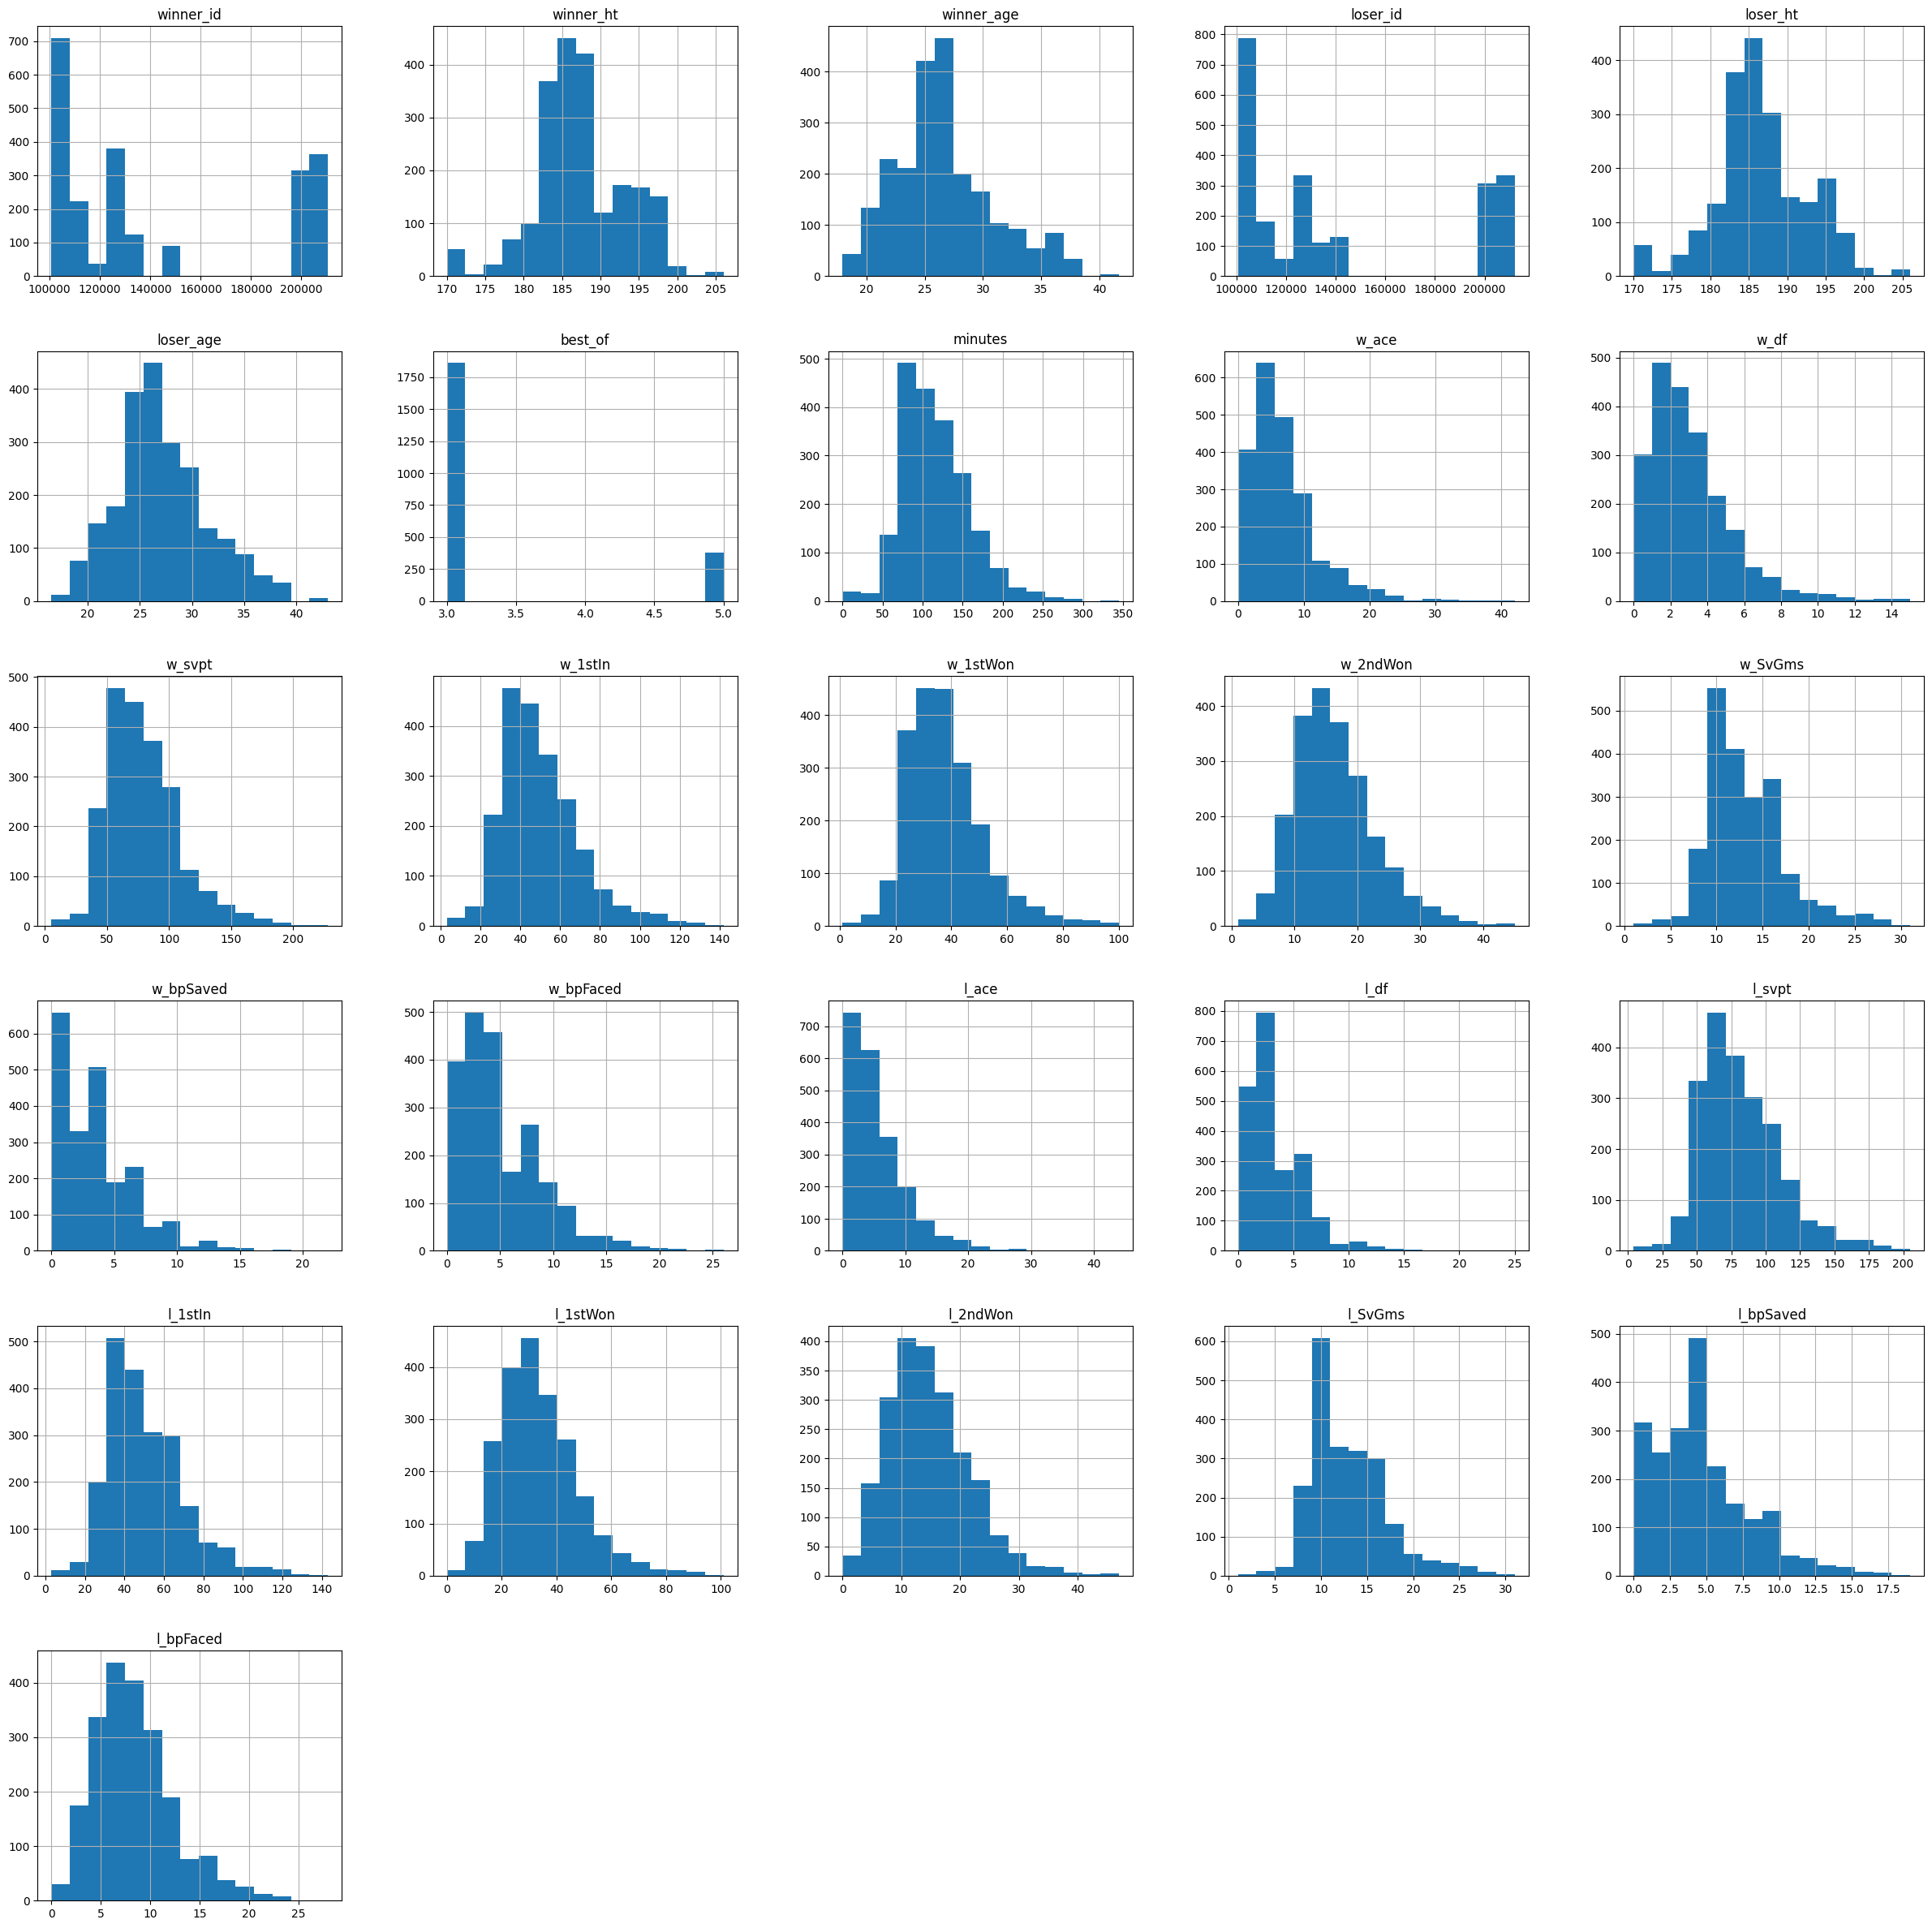

In [7]:
data.hist(figsize=(30,30), bins=15);

Podemos ver que la mayoría de las columnas siguen una distribución relativamente normal

In [8]:
for i in data.select_dtypes(include=object):
    print(f"La cardinalidad de la variable {i} es {(data[i].nunique()/data.shape[0])*100:.2f}%")

La cardinalidad de la variable tourney_name es 3.52%
La cardinalidad de la variable surface es 0.13%
La cardinalidad de la variable tourney_level es 0.18%
La cardinalidad de la variable winner_hand es 0.13%
La cardinalidad de la variable winner_ioc es 2.81%
La cardinalidad de la variable loser_hand es 0.13%
La cardinalidad de la variable loser_ioc es 3.12%
La cardinalidad de la variable round es 0.36%


In [9]:
for i in data.select_dtypes(exclude=object):
    print(f"La cardinalidad de la variable {i} es {(data[i].nunique()/data.shape[0])*100:.2f}%")

La cardinalidad de la variable winner_id es 11.28%
La cardinalidad de la variable winner_ht es 0.76%
La cardinalidad de la variable winner_age es 8.65%
La cardinalidad de la variable loser_id es 15.52%
La cardinalidad de la variable loser_ht es 0.76%
La cardinalidad de la variable loser_age es 9.28%
La cardinalidad de la variable best_of es 0.09%
La cardinalidad de la variable minutes es 9.77%
La cardinalidad de la variable w_ace es 1.56%
La cardinalidad de la variable w_df es 0.71%
La cardinalidad de la variable w_svpt es 7.58%
La cardinalidad de la variable w_1stIn es 5.53%
La cardinalidad de la variable w_1stWon es 4.15%
La cardinalidad de la variable w_2ndWon es 1.96%
La cardinalidad de la variable w_SvGms es 1.34%
La cardinalidad de la variable w_bpSaved es 0.94%
La cardinalidad de la variable w_bpFaced es 1.12%
La cardinalidad de la variable l_ace es 1.56%
La cardinalidad de la variable l_df es 0.94%
La cardinalidad de la variable l_svpt es 7.45%
La cardinalidad de la variable l_

En cuanto a la cardinalidad, podemos ver que los valores son muy variados, las que  mayor tienen son winner_id y loser_id, lo cual es coherente porque son los jugadores de cada partido,
que casi siempre son los mismos los que participan en cada torneo

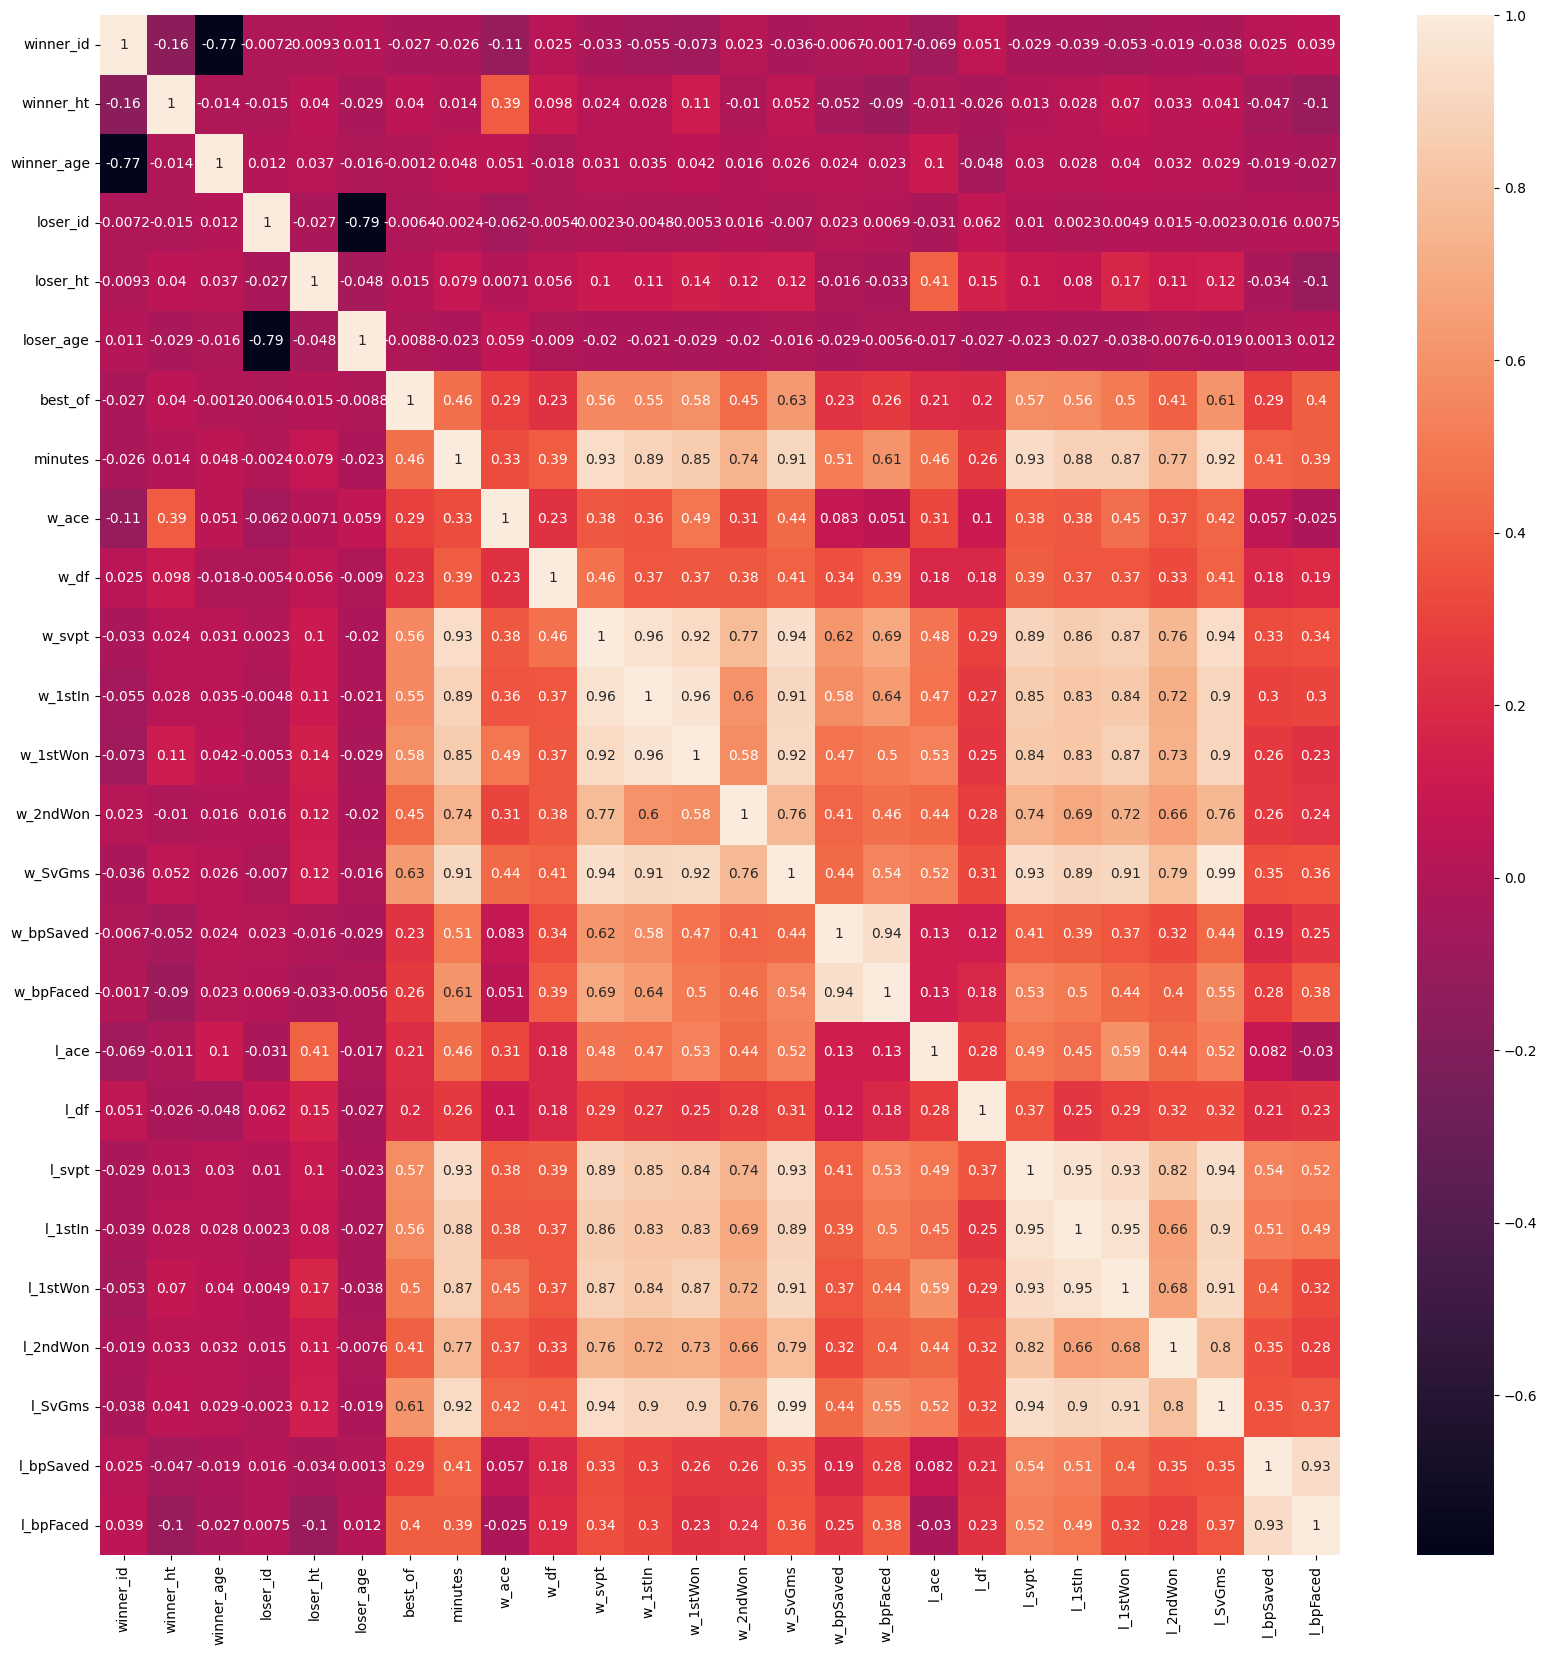

In [10]:
plt.figure(figsize=(20,20))
sns.heatmap(data.corr(numeric_only=True), annot=True);

Las variables que peores correlaciones tienen son las que se refieren a la altura (winner_ht y loser_ht), identificador (winner_id y loser_id) y edad (winner_age y loser_age) de los jugadores

# Tratamiento de NaNs

In [11]:
data.dropna(subset=['w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon'], inplace=True)

In [12]:
data["winner_ht"].fillna(data["winner_ht"].mean(), inplace=True)
data["loser_ht"].fillna(data["loser_ht"].mean(), inplace=True)
data["loser_age"].fillna(data["loser_age"].mean(), inplace=True)
data["minutes"].fillna(data["minutes"].mean(), inplace=True)

# Escalado de datos

In [13]:
le = LabelEncoder()

data["tourney_name"] = le.fit_transform(data["tourney_name"])
data["winner_ioc"] = le.fit_transform(data["winner_ioc"])
data["loser_ioc"] = le.fit_transform(data["loser_ioc"])
data["round"] = le.fit_transform(data["round"])
data.head()

,tourney_name,surface,tourney_level,winner_id,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_hand,loser_ht,loser_ioc,loser_age,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced
0,46,Hard,A,126203,R,193.0,43,25.1,126610,R,196.0,28,26.7,3,0,135.0,15.0,2.0,85.0,52.0,45.0,16.0,12.0,0.0,0.0,7.0,2.0,97.0,62.0,47.0,15.0,12.0,9.0,9.0
1,46,Hard,A,126207,R,188.0,43,24.9,207518,R,185.0,28,20.8,3,0,34.0,3.0,1.0,27.0,19.0,15.0,3.0,4.0,3.0,3.0,0.0,0.0,21.0,12.0,8.0,3.0,4.0,1.0,3.0
2,46,Hard,A,126203,R,193.0,43,25.1,128034,R,196.0,41,25.8,3,7,104.0,11.0,0.0,80.0,50.0,44.0,19.0,12.0,4.0,4.0,17.0,1.0,82.0,62.0,51.0,7.0,12.0,2.0,2.0
3,46,Hard,A,126207,R,188.0,43,24.9,200390,R,183.0,41,23.9,3,7,79.0,5.0,4.0,61.0,37.0,31.0,11.0,9.0,5.0,5.0,3.0,3.0,68.0,41.0,26.0,12.0,9.0,6.0,9.0
4,46,Hard,A,126774,R,193.0,23,24.3,126610,R,196.0,28,26.7,3,7,155.0,9.0,1.0,98.0,52.0,43.0,28.0,16.0,1.0,2.0,7.0,2.0,89.0,58.0,48.0,18.0,16.0,1.0,2.0


A las columnas categóricas con mayor número de valores les he aplicado un LabelEncoder para escalarlas

In [14]:
map_surface = {"Hard":0, "Clay": 1, "Grass":2}
map_hand = {"R":0, "L": 1, "U":2}
map_tourney = {"A":0, "M": 1, "G":2}

data["surface"].replace(map_surface, inplace=True)
data["loser_hand"].replace(map_hand, inplace=True)
data["winner_hand"].replace(map_hand, inplace=True)
data["tourney_level"].replace(map_tourney, inplace=True)

data["tourney_level"] = data["tourney_level"].astype("int32")
data.head()

,tourney_name,surface,tourney_level,winner_id,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_hand,loser_ht,loser_ioc,loser_age,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced
0,46,0,0,126203,0,193.0,43,25.1,126610,0,196.0,28,26.7,3,0,135.0,15.0,2.0,85.0,52.0,45.0,16.0,12.0,0.0,0.0,7.0,2.0,97.0,62.0,47.0,15.0,12.0,9.0,9.0
1,46,0,0,126207,0,188.0,43,24.9,207518,0,185.0,28,20.8,3,0,34.0,3.0,1.0,27.0,19.0,15.0,3.0,4.0,3.0,3.0,0.0,0.0,21.0,12.0,8.0,3.0,4.0,1.0,3.0
2,46,0,0,126203,0,193.0,43,25.1,128034,0,196.0,41,25.8,3,7,104.0,11.0,0.0,80.0,50.0,44.0,19.0,12.0,4.0,4.0,17.0,1.0,82.0,62.0,51.0,7.0,12.0,2.0,2.0
3,46,0,0,126207,0,188.0,43,24.9,200390,0,183.0,41,23.9,3,7,79.0,5.0,4.0,61.0,37.0,31.0,11.0,9.0,5.0,5.0,3.0,3.0,68.0,41.0,26.0,12.0,9.0,6.0,9.0
4,46,0,0,126774,0,193.0,23,24.3,126610,0,196.0,28,26.7,3,7,155.0,9.0,1.0,98.0,52.0,43.0,28.0,16.0,1.0,2.0,7.0,2.0,89.0,58.0,48.0,18.0,16.0,1.0,2.0


Al resto de variables categóricas, al tener muy pocos valores distintos, les he aplicado un mapeo simple

# División de datos y Train-Test

In [27]:
X = data.drop(columns=["minutes", "tourney_name", "surface",	"tourney_level",'winner_ioc','loser_ioc','winner_ht','loser_ht'], axis=1)
X = np.log(X + 1)

y = data["minutes"]

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 42)

# Croos Validation y Base Lines

In [29]:
from sklearn.linear_model import ElasticNet
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


modelos = {
    "Linear Regression": LinearRegression(),
   "Ridge": Ridge(alpha=0.1, solver="cholesky"),
    "Lasso": Lasso(alpha=0.1),
    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5),
    "LinearSVR": LinearSVR(epsilon=0.5, dual=True, random_state=42),
    "DecissionTree":DecisionTreeRegressor(max_depth=2, random_state=42),
    "RandomForest":RandomForestRegressor(n_estimators=10, random_state=42)
}

# Define las métricas a usar
metricas = ["neg_mean_absolute_percentage_error", "neg_root_mean_squared_error"]

resultados_dict = {}

for nombre_modelo, modelo in modelos.items():
    cv_resultados = cross_validate(modelo, X_train, y_train, cv=5, scoring=metricas)
    
    for metrica in metricas:
        clave = f"{nombre_modelo}_{metrica}"
        resultados_dict[clave] = cv_resultados[f"test_{metrica}"].mean()

# Convertir el diccionario de resultados en DataFrame
resultados_df = pd.DataFrame([resultados_dict])

In [30]:
data["minutes"].mean().round(2)

116.0

In [31]:
resultados_df = resultados_df.T
abs(resultados_df).sort_values(by=0, ascending=True)

,0
RandomForest_neg_mean_absolute_percentage_error,0.099385
Ridge_neg_mean_absolute_percentage_error,0.138925
Linear Regression_neg_mean_absolute_percentage_error,0.138967
Lasso_neg_mean_absolute_percentage_error,0.139125
ElasticNet_neg_mean_absolute_percentage_error,0.139211
LinearSVR_neg_mean_absolute_percentage_error,0.140623
DecissionTree_neg_mean_absolute_percentage_error,0.171127
RandomForest_neg_root_mean_squared_error,18.578910
Ridge_neg_root_mean_squared_error,19.855169
Linear Regression_neg_root_mean_squared_error,19.857553


He hecho el CV con RandomForestRegressor, LinearRegressor, Ridge... aplicando las métricas MAPE y MSE, y el que mejor resultado da es el modelo RandomForestRegressor con MAPE, que da un 9% de error

In [32]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'bootstrap': [True,False],
    'max_depth': [50, 80],
    'max_features': [15, 30],
    'min_samples_leaf': [3,5],
    'min_samples_split': [8, 10],
    'n_estimators': [500, 1000]
}

tree = RandomForestRegressor()

grid_search = GridSearchCV(tree,
                           param_grid,
                           cv=5,
                           scoring='neg_mean_absolute_percentage_error',
                           n_jobs=-1
                          )
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [50, 80],
                         'max_features': [15, 30], 'min_samples_leaf': [3, 5],
                         'min_samples_split': [8, 10],
                         'n_estimators': [500, 1000]},
             scoring='neg_mean_absolute_percentage_error')

In [33]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 15,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 500}

Aplicando GridSearch, vemos que estos son los mejors hiperparámetros, con los que reentrenamos el modelo

In [55]:
rforest = RandomForestRegressor(bootstrap= False, max_depth= 80, max_features= 15, min_samples_leaf= 3, min_samples_split= 8, n_estimators= 500)
rforest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, max_depth=80, max_features=15,
                      min_samples_leaf=3, min_samples_split=8,
                      n_estimators=500)

In [56]:
rforest.score(X_test, y_test)

0.8176398772729265

In [57]:
from sklearn.metrics import mean_absolute_percentage_error

pred = rforest.predict(X_test)
mean_absolute_percentage_error(y_test, pred)

0.08878358008085609

Aplicando la función de sklearn a la predicción vemos que nos da un mejor resultado que con CV

# No supervisado: PCA

Realizamos un PCA con 2 componentes para ver si conseguimos mejorar los reultados del supervisado

In [58]:
from sklearn.decomposition import PCA


pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_train)

In [59]:
pca.score(X_test, y_test)

-9.922382462780106

Como no se mejora el score del modelo supervisado, nos quedamos con RandomTreeRegressor como mejor modelo